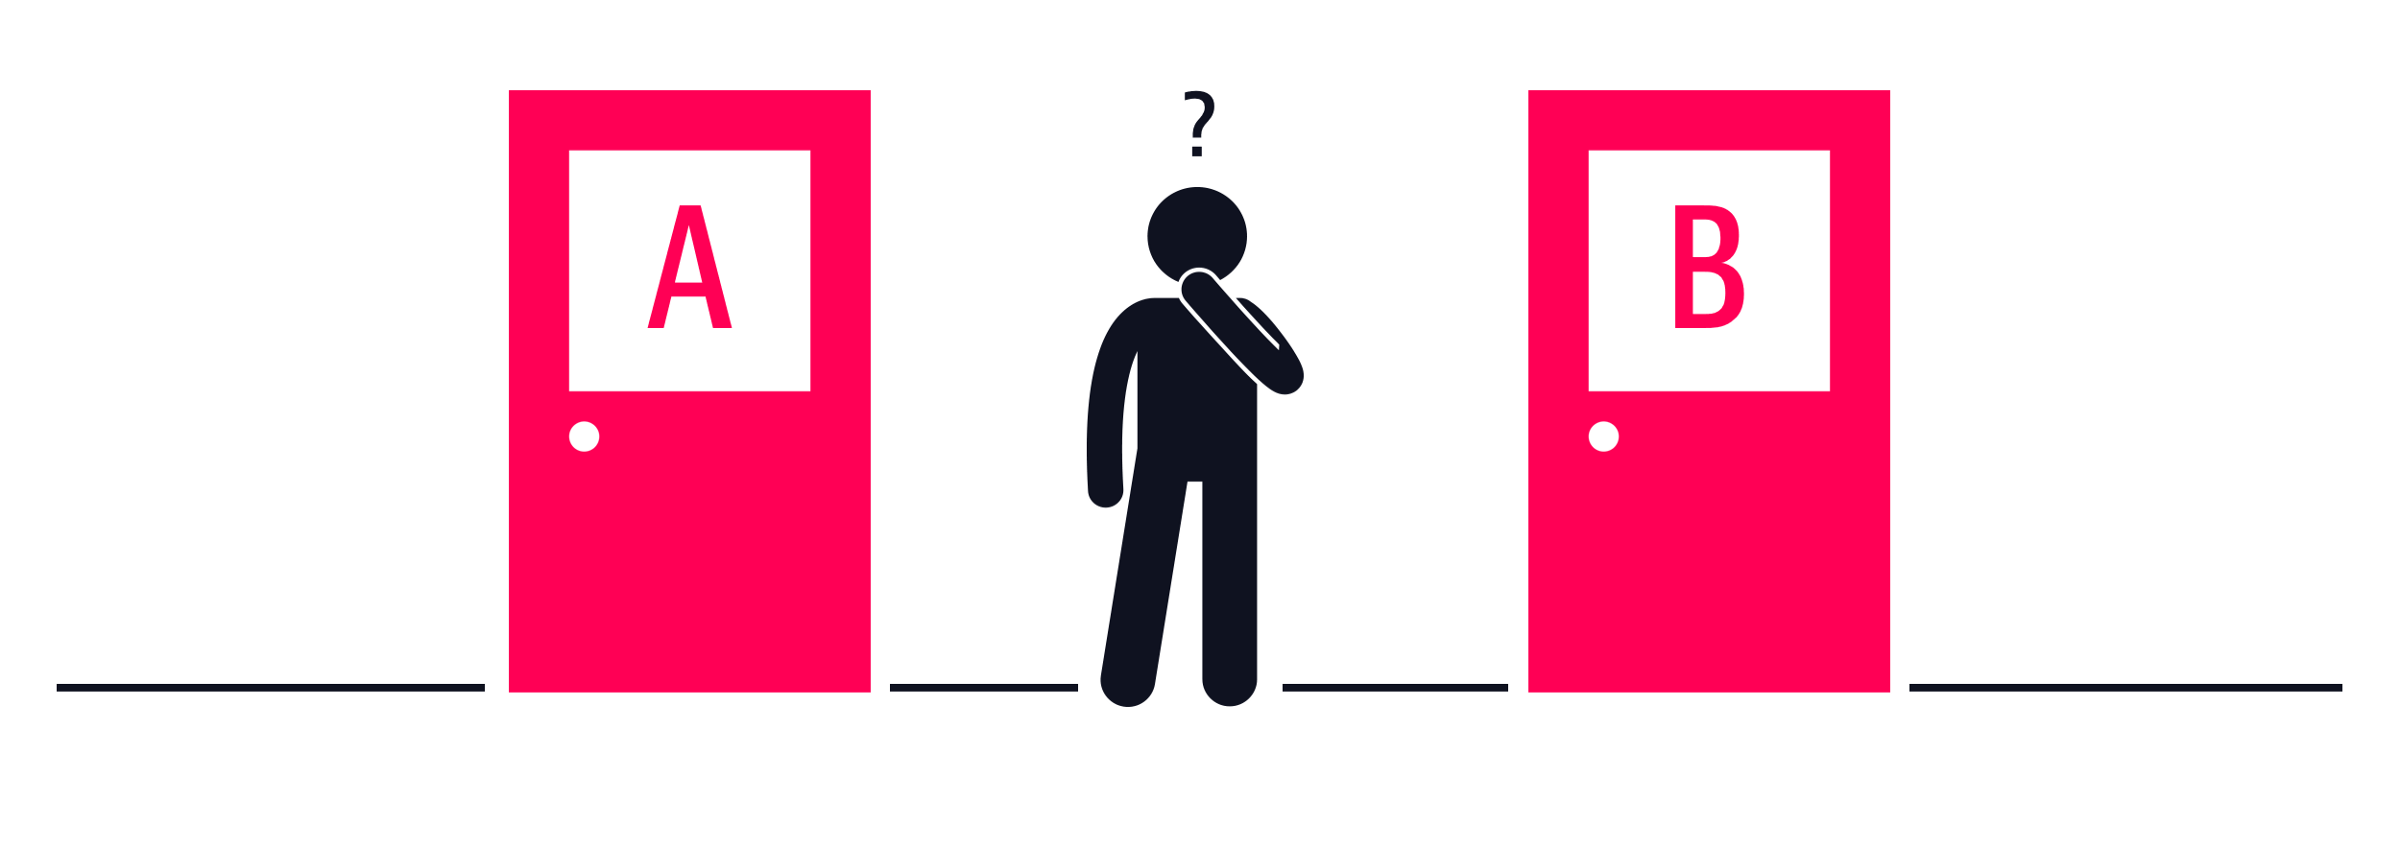

## Библиотеки 

In [18]:
import numpy as np
import pandas as pd
import scipy.stats
from matplotlib import pyplot as plt

import seaborn as sns
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [2]:
import sys

In [3]:
sys.path.append('..')

In [4]:
from stattests.generation import generate_data
from stattests.utils import plot_cdf

## Подготовка

[Исходная статья](https://vkteam.medium.com/practitioners-guide-to-statistical-tests-ed2d580ef04f)

### Определение метрики CTR (click-through rate):

- Формула: (количество кликов / количество показов) * 100. Источник [Wiki_RU](https://ru.wikipedia.org/wiki/CTR_(%D0%98%D0%BD%D1%82%D0%B5%D1%80%D0%BD%D0%B5%D1%82))
- Формула в статье: (количество кликов / количество уникальных пользователей) = "average number of clicks per user"

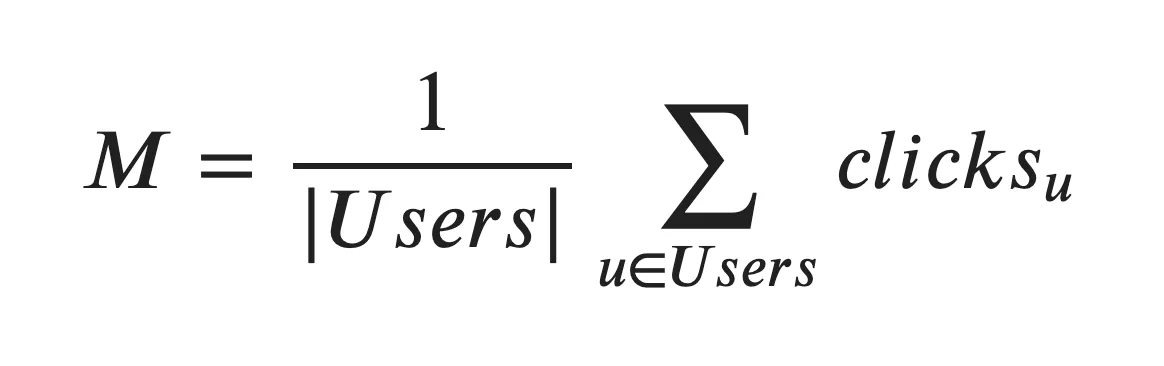

**Определение групп пользователей**:
- *Control group* - we will use our current production model
- *Treatment group* - we will deploy the new CTR prediction model

### Hypothesis Testing 

- The null hypothesis states that nothing has changed. In our example, it would be “the average number of clicks in the control and treatment groups are the same”.
- The alternative hypothesis says that there is a notable difference between groups.

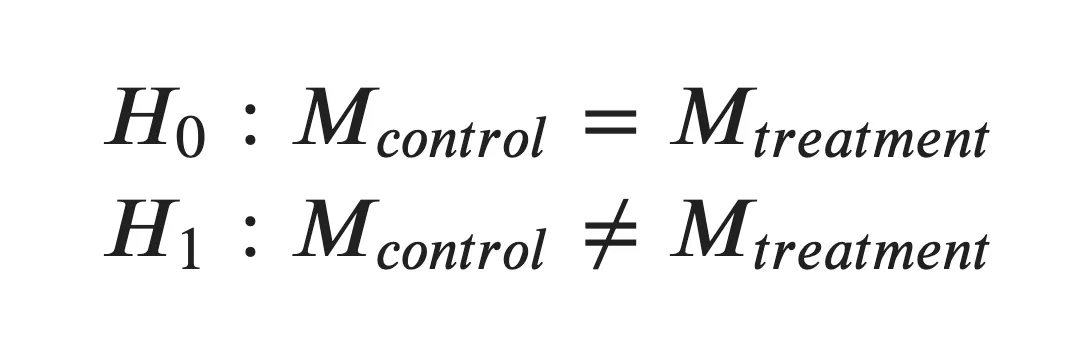

**False-positive rate (FPR)**  
FPR is the probability of rejecting H0 while it is actually true.  
If a statistical procedure is correct (all assumptions are met and the statistical test works fine with the given data), this rate is controlled by **p-value**.

**Sensitivity**  
Sensitivity is the probability of rejecting H0 while it is actually not true.

**Вопросы:**  
    - Как связаны FPR и ошибка первого рода? А Sensitivity и ошибка второго рода?  
    - Какие значения примет FPR и Sensitivity, если мы будем всегда принимать нулевую гипотезу? А если отвергать?

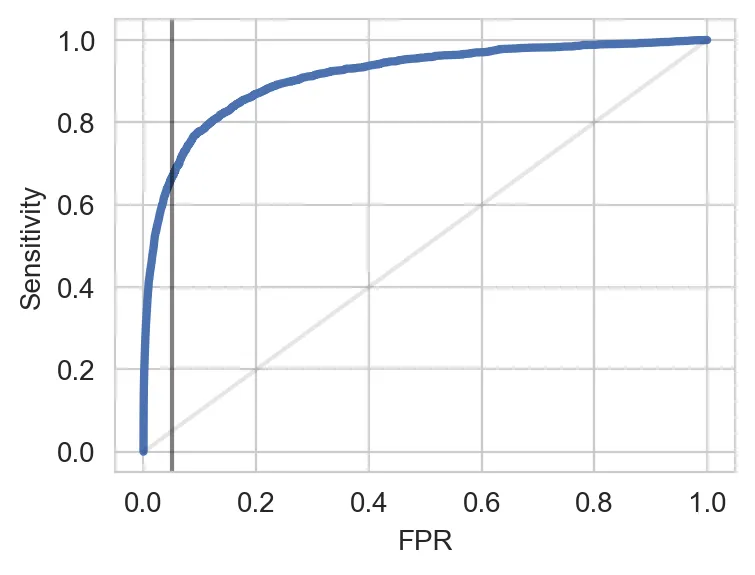

**FPR versus sensitivity (Mann-Whitney test)** 

The vertical grey line corresponds to 5% FPR, the standard p-value threshold. The intersection of this line with the curve gives you the sensitivity of your test that corresponds to 5% FPR. We will call it **the power of the statistical test** at 5% FPR (or just power). In this example, the power of the standard Mann-Whitney test at 5% FPR is 65%.

**The goal:**  
We will fix FPR to 5% and compare the powers of a vast variety of tests given this level.

**Power of the statistical test depends on four things:**

- The test itself
- Distribution of the experimental data
- Effect size
- Size of the test groups

### Data Generation 

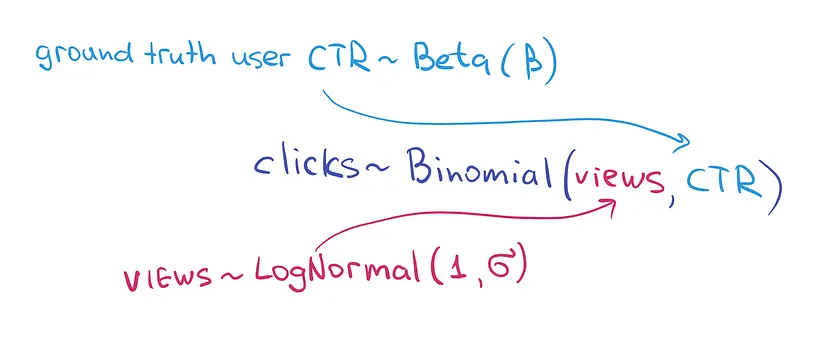

#### Views 

- skew: float, skewness of views distribution
- N: int, number of users in each experimental group (in control and in treatment)

In [14]:
skew = 2
N = 5000

[Log-normal distribution](https://en.wikipedia.org/wiki/Log-normal_distribution)  
[scipy.stats.norm](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html#scipy.stats.norm)

In [15]:
views = np.exp(scipy.stats.norm(1, skew).rvs(N)).astype(int) + 1

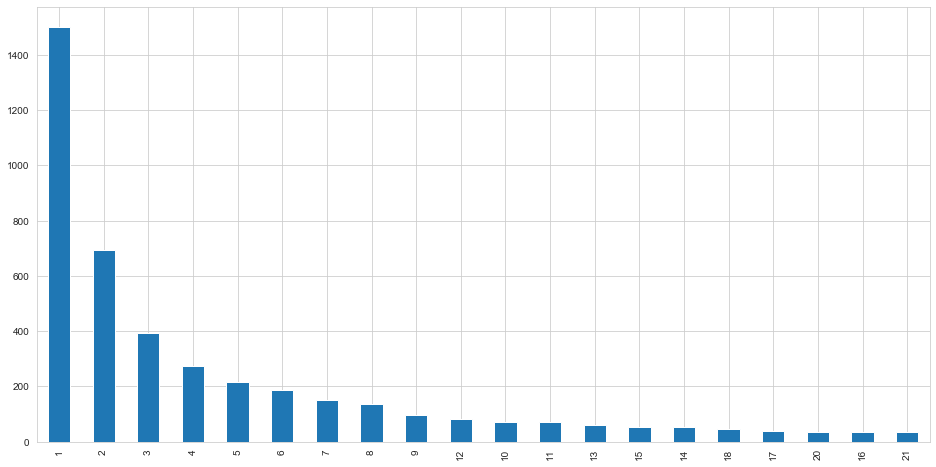

In [16]:
pd.Series(views).value_counts().iloc[0:20].plot(kind='bar', figsize=(16, 8))

Most of the users saw a small number of ads, and few users — a lot.

#### Ground Truth User CTR

- mean_success_rate: mean success rate in control group
- beta: parameter of success rate distribution

In [70]:
mean_success_rate = 0.2
beta = 1000

[Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution)  
[scipy.stats.beta](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.beta.html)

In [71]:
alpha = mean_success_rate * beta / (1 - mean_success_rate) # показать формулу среднего
success_rate = scipy.stats.beta(alpha, beta).rvs(N)

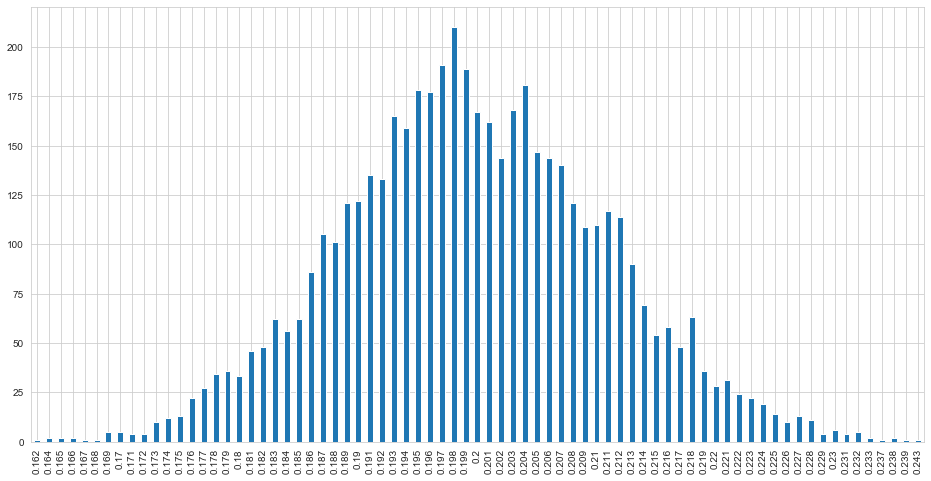

In [72]:
pd.Series(success_rate).round(3).value_counts().sort_index().plot(kind='bar', figsize=(16, 8))

#### Clicks

[Binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution)  
[scipy.stats.binom](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binom.html)

In [38]:
clicks = scipy.stats.binom(n=views, p=success_rate).rvs()

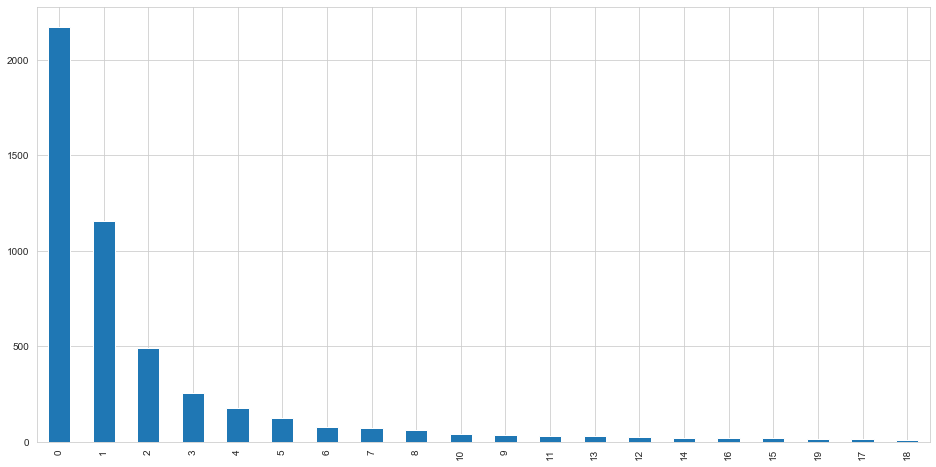

In [39]:
pd.Series(clicks).value_counts().iloc[0:20].plot(kind='bar', figsize=(16, 8))

#### Все вместе

In [47]:
df = pd.DataFrame(zip(views, success_rate, clicks), columns=['views', 'success_rate', 'clicks'])

In [48]:
df.head()

,views,success_rate,clicks
0,2,0.190149,0
1,3,0.200151,0
2,15,0.212838,3
3,4,0.200181,1
4,22,0.213778,5


In [49]:
df.shape

(5000, 3)

In [50]:
df.describe()

,views,success_rate,clicks
count,5000.000000,5000.000000,5000.000000
mean,22.158000,0.199933,4.450800
std,136.392268,0.011415,27.651678
min,1.000000,0.160783,0.000000
25%,1.000000,0.192354,0.000000
50%,3.000000,0.199708,1.000000
75%,11.000000,0.207497,2.000000
max,5964.000000,0.240468,1208.000000


#### Treatment group  

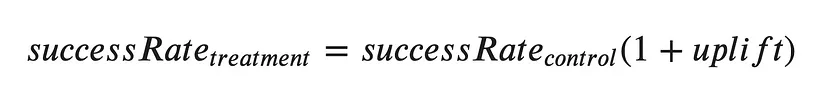

**Whole pipeline**
- Initialize N users for the control group, N for the treatment group.
- Generate the number of ad views for each user in treatment and control groups from the same log-normal distribution.
- Generate the ground truth user CTR for each user from beta-distribution with mean **success_rate_control** for the control group and **success_rate_control * (1 + uplift)** for the treatment group.
- Generate the number of ad clicks for each user from a binomial distribution with the number of trials equal to the number of views and the success rate equal to the ground truth user CTR.

In [32]:
ab_params = {'success_rate': 0.02,
             'uplift': 0.1,
             'beta': 1000,
             'skew': 2,
             'N': 10000,
             'NN': 1}
(views_0_ab, clicks_0_ab), (views_1_ab, clicks_1_ab), (success_rates_0_ab, success_rates_1_ab) = generate_data(**ab_params)

df_control = pd.DataFrame(zip(views_0_ab[0], success_rates_0_ab[0], clicks_0_ab), columns=['views', 'success_rates', 'clicks'])
df_treatment = pd.DataFrame(zip(views_1_ab[0], success_rates_1_ab[0], clicks_1_ab), columns=['views','success_rates', 'clicks'])

In [33]:
df_control.head()

,views,success_rates,clicks
0,1.0,0.017625,0.0
1,2.0,0.015530,0.0
2,6.0,0.025502,0.0
3,1.0,0.029048,0.0
4,19.0,0.016019,0.0


In [34]:
df_control.shape

(10000, 3)

In [35]:
ctr_control = df_control.clicks.mean()
ctr_control

0.4177

In [36]:
ctr_treatment = df_treatment.clicks.mean()
ctr_treatment

0.4545

In [37]:
ctr_treatment / ctr_control

1.0881015082595165

In [38]:
df_control.clicks.describe()

count    10000.000000
mean         0.417700
std          2.434835
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        170.000000
Name: clicks, dtype: float64

In [30]:
df_treatment.clicks.describe()

count    10000.000000
mean         1.481400
std         21.898639
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max       1782.000000
Name: clicks, dtype: float64

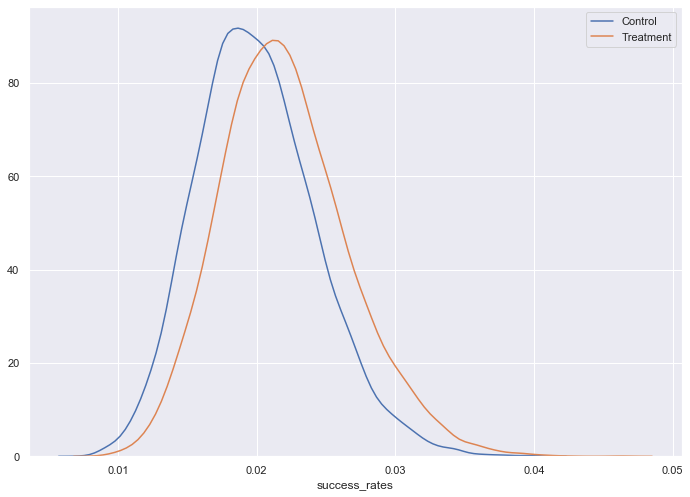

In [39]:
sns.distplot(df_control.success_rates, hist=False, label="Control")
sns.distplot(df_treatment.success_rates, hist=False, label="Treatment")

### Sensitivity and p-value CDF 

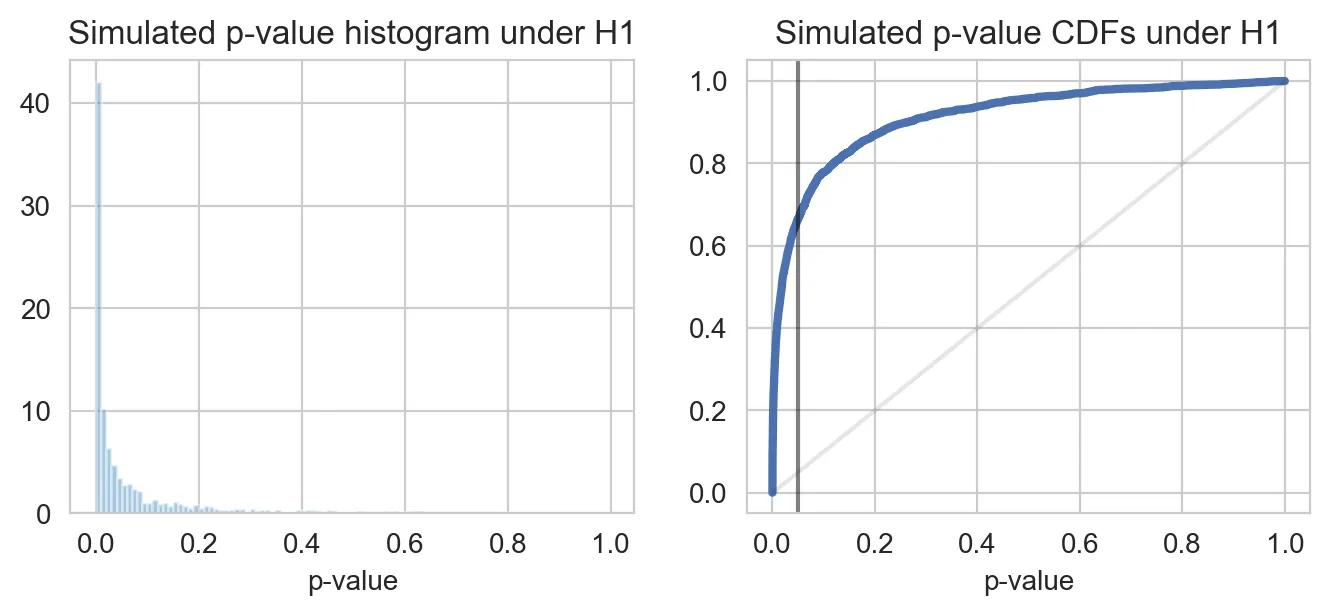

And there’s something even trickier. Note how the p-value CDF here is actually equal to the statistical test sensitivity. If we were to take the CDF’s value at 0.05 p-value, this would actually be the fraction of experiments when p-value <= 0.05. CDF(0.05) is the fraction of experiments when we reject H0. And as we know that H0 is not true in all experiments, CDF(0.05) is the fraction of experiments in which we reject H0 when H0 is actually not true (sensitivity). So the plot we see here is exactly the ROC curve for the statistical test (sensitivity vs FPR). We will use this approach to plot ROC curves for a wide variety of statistical tests and to compare them.

### P-value sanity check

- We always claim that False Positive Rate is controlled by a p-value threshold
- If p-value controls FPR reasonably well, the test will give us the correct results despite the violation of the assumptions.
- So for every statistical test, we should be able to check whether p-value controls FPR for our data.

A/A tests:
- Let’s use the same data generation pipeline, but with zero uplift.
- The p-value correctly controls FPR if and only if the p-value is distributed uniformly on [0, 1] for A/A tests.
-  We claim that in this case FPR is equal to our p-value threshold, e.g. for A/A tests, p-value falls below the 0.05 threshold in only 5% of cases. 

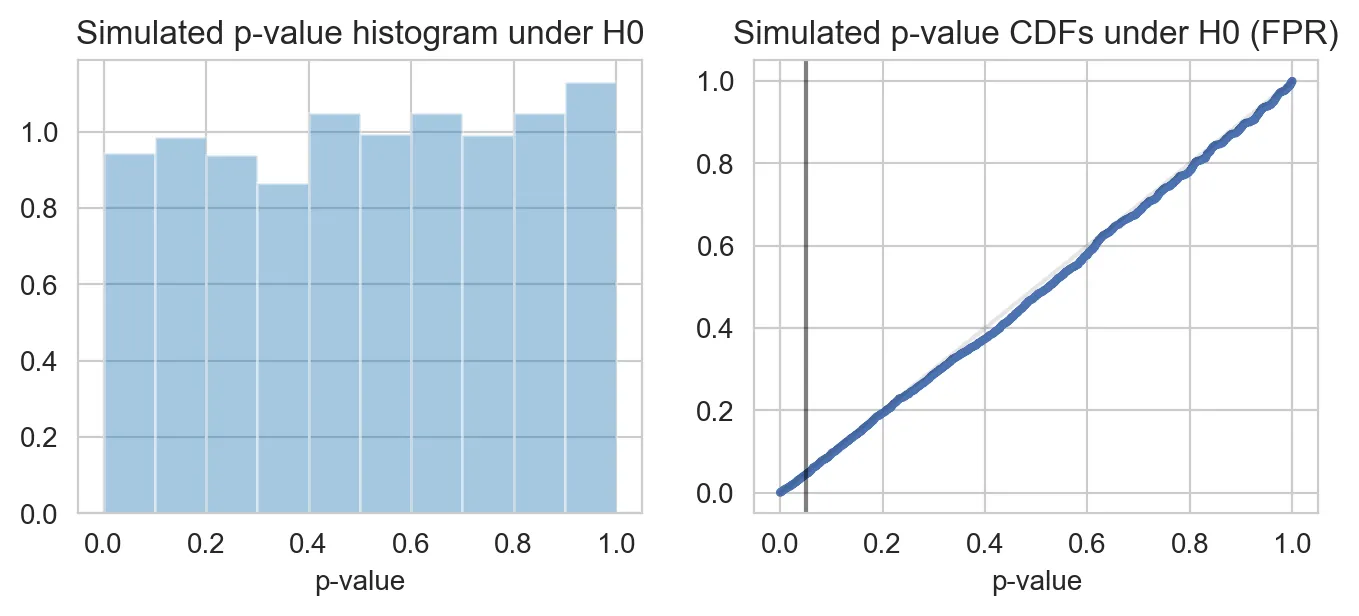

**TODO:** показать механизм получения этих графиков.  
**TODO:** есть еще отдельный тест для проверки диагональности графика

## Tests on the number of clicks

###  T-test on the number of clicks 

T-tests involve strong assumptions on data, such as normality and equal variances among test groups. However, empirically, t-tests are robust to violations of the assumptions.

**Параметры по умолчанию**

TODO: сделать краткие выводы о крайних случаях.

In [4]:
skew = 1.0 # float, skewness of views distribution
N = 5000 # number of users in each experimental group (in control and in treatment)
NN = 2000 # number of experiments
success_rate = 0.02 # mean success rate in control group
uplift = 0.2 # relative uplift of mean success rate in treatment group
beta = 1000 # parameter of success rate distribution

In [7]:
skew_params = []
for s in np.linspace(0.1, 4, 20):
    skew_params.append({'success_rate': success_rate, 'uplift': uplift, 'beta': beta, 'skew': s, 'N': N, 'NN': NN})

In [10]:
print(np.linspace(0.1, 4, 20))

[0.1        0.30526316 0.51052632 0.71578947 0.92105263 1.12631579
 1.33157895 1.53684211 1.74210526 1.94736842 2.15263158 2.35789474
 2.56315789 2.76842105 2.97368421 3.17894737 3.38421053 3.58947368
 3.79473684 4.        ]


[Logarithmic scale](https://en.wikipedia.org/wiki/Logarithmic_scale)

In [8]:
beta_params = []
for b in np.logspace(0, 3, 20)[::-1]:
    beta_params.append({'success_rate': success_rate, 'uplift': uplift, 'beta': b, 'skew': skew, 'N': N, 'NN': NN})

In [11]:
print(np.logspace(0, 3, 20)[::-1])

[1000.          695.19279618  483.29302386  335.98182863  233.57214691
  162.37767392  112.88378917   78.47599704   54.55594781   37.92690191
   26.36650899   18.32980711   12.74274986    8.8586679     6.15848211
    4.2813324     2.97635144    2.06913808    1.43844989    1.        ]


TODO: почему здесь поменяли 'beta'?

In [9]:
sr_params = []
for sr in np.logspace(-3, -0.3, 20):
    sr_params.append({'success_rate': sr, 'uplift': uplift, 'beta': 500, 'skew': skew, 'N': N, 'NN': NN})

In [12]:
print(np.logspace(-3, -0.3, 20))

[0.001      0.00138709 0.00192402 0.0026688  0.00370187 0.00513483
 0.00712249 0.00987954 0.01370383 0.01900848 0.02636651 0.03657277
 0.0507298  0.0703669  0.09760536 0.13538762 0.18779508 0.26048905
 0.36132228 0.50118723]


In [39]:
param_list = skew_params + beta_params + sr_params
len(param_list)

60

In [42]:
param = param_list[33]
param

{'success_rate': 0.02,
 'uplift': 0.2,
 'beta': 8.858667904100825,
 'skew': 1.0,
 'N': 5000,
 'NN': 2000}

In [43]:
ab_params = {'success_rate': param['success_rate'],
             'uplift': param['uplift'],
             'beta': param['beta'],
             'skew': param['skew'],
             'N': param['N'],
             'NN': param['NN']}

aa_params = {'success_rate': param['success_rate'],
             'uplift': 0,
             'beta': param['beta'],
             'skew': param['skew'],
             'N': param['N'],
             'NN': param['NN']}

In [48]:
(views_0_ab, clicks_0_ab), (views_1_ab, clicks_1_ab), gt_success_rates = generate_data(**ab_params)
(views_0_aa, clicks_0_aa), (views_1_aa, clicks_1_aa), _ = generate_data(**aa_params)

In [51]:
views_0_ab.shape

(2000, 5000)

In [52]:
clicks_0_ab.shape

(2000, 5000)

In [56]:
gt_success_rates.shape

(2000, 5000)

In [73]:
views_control = views_0_ab[555,:]
clicks_control = clicks_0_ab[555,:]

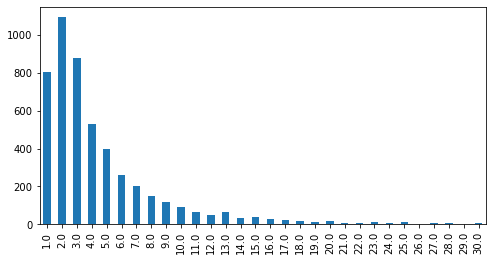

In [74]:
pd.Series(views_control).value_counts().sort_index().loc[0:30].plot(kind='bar', figsize=(8, 4))

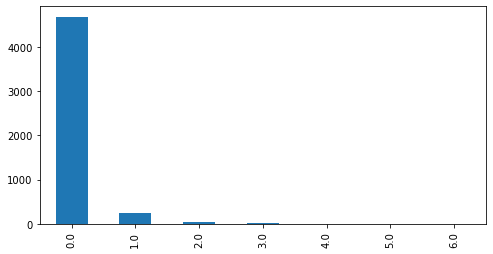

In [75]:
pd.Series(clicks_control).value_counts().sort_index().loc[0:30].plot(kind='bar', figsize=(8, 4))

In [76]:
np.mean(clicks_control)

0.0846

In [77]:
views_treatment = views_1_ab[555,:]
clicks_treatment = clicks_1_ab[555,:]

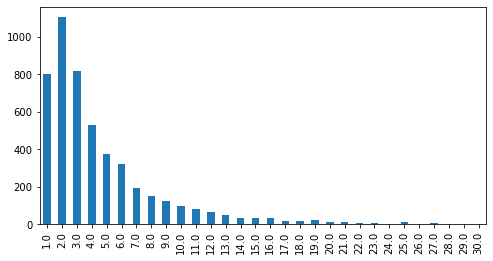

In [78]:
pd.Series(views_treatment).value_counts().sort_index().loc[0:30].plot(kind='bar', figsize=(8, 4))

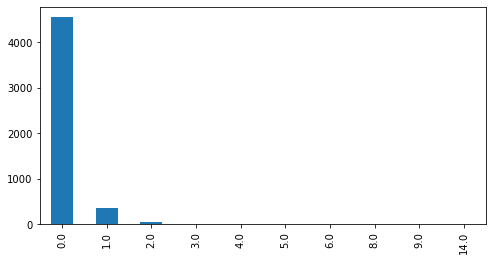

In [79]:
pd.Series(clicks_treatment).value_counts().sort_index().loc[0:30].plot(kind='bar', figsize=(8, 4))

In [80]:
np.mean(clicks_treatment)

0.1254

In [81]:
np.mean(clicks_treatment) / np.mean(clicks_control)

1.4822695035460995

In [89]:
pd.Series(map(np.mean, clicks_0_ab)).describe()

count    2000.000000
mean        0.099727
std         0.006612
min         0.079200
25%         0.095400
50%         0.099400
75%         0.103800
max         0.125200
dtype: float64

In [90]:
pd.Series(map(np.mean, clicks_1_ab)).describe()

count    2000.000000
mean        0.119751
std         0.007274
min         0.099600
25%         0.114800
50%         0.119400
75%         0.124000
max         0.145000
dtype: float64

In [91]:
pd.Series(map(np.mean, views_0_ab)).describe()

count    2000.000000
mean        4.977858
std         0.083566
min         4.737000
25%         4.921350
50%         4.974900
75%         5.033850
max         5.320000
dtype: float64

In [92]:
pd.Series(map(np.mean, views_1_ab)).describe()

count    2000.000000
mean        4.980444
std         0.081653
min         4.713600
25%         4.926150
50%         4.978800
75%         5.036200
max         5.257600
dtype: float64

In [93]:
pd.Series(map(np.mean, clicks_0_aa)).describe()

count    2000.000000
mean        0.099552
std         0.006546
min         0.080000
25%         0.095200
50%         0.099400
75%         0.104000
max         0.121600
dtype: float64

In [94]:
pd.Series(map(np.mean, clicks_1_aa)).describe()

count    2000.000000
mean        0.099782
std         0.006613
min         0.078000
25%         0.095200
50%         0.099600
75%         0.104200
max         0.124000
dtype: float64

In [95]:
pd.Series(map(np.mean, views_0_aa)).describe()

count    2000.000000
mean        4.981991
std         0.084221
min         4.685000
25%         4.924000
50%         4.981900
75%         5.039250
max         5.308200
dtype: float64

In [96]:
pd.Series(map(np.mean, views_1_aa)).describe()

count    2000.000000
mean        4.979651
std         0.081397
min         4.736800
25%         4.924750
50%         4.975700
75%         5.034050
max         5.312400
dtype: float64

In [97]:
def t_test(a, b):
    """
    Calculates two-sided t-test p-values for multiple experiments
    :param a: np.array shape (n_experiments, n_users), metric values in control group
    :param b: np.array shape (n_experiments, n_users), metric values in treatment group
    :return: np.array shape (n_experiments), two-sided p-values of t-test in all experimetns
    """
    result = list(map(lambda x: scipy.stats.ttest_ind(x[0], x[1]).pvalue, zip(a, b)))
    return np.array(result)

In [98]:
ab_data = t_test(clicks_0_ab, clicks_1_ab)
aa_data = t_test(clicks_0_aa, clicks_1_aa)

In [100]:
ab_data.shape

(2000,)

In [101]:
aa_data.shape

(2000,)

In [102]:
pd.Series(ab_data).describe()

count    2.000000e+03
mean     1.377373e-01
std      2.166603e-01
min      1.060133e-07
25%      6.861064e-03
50%      3.747505e-02
75%      1.625107e-01
max      1.000000e+00
dtype: float64

In [103]:
pd.Series(aa_data).describe()

count    2000.000000
mean        0.495655
std         0.288452
min         0.001792
25%         0.243660
50%         0.491365
75%         0.740912
max         1.000000
dtype: float64

In [104]:
figsize = (4, 3)
dpi = 200

```python
def plot_cdf(data: np.ndarray, label: str, ax: Axes, color: str = colors[0], linewidth: float = 3):
    sorted_data = np.sort(data)
    position = scipy.stats.rankdata(sorted_data, method='ordinal')
    cdf = position / data.shape[0]

    sorted_data = np.hstack((sorted_data, 1))
    cdf = np.hstack((cdf, 1))

    return ax.plot(sorted_data, cdf, color=color, linestyle='solid', label=label, linewidth=linewidth)
```

In [112]:
sorted_data = np.sort(ab_data)

In [116]:
position = scipy.stats.rankdata(sorted_data, method='ordinal')
position

array([   1,    2,    3, ..., 1998, 1999, 2000], dtype=int64)

In [119]:
cdf = position / ab_data.shape[0]
cdf

array([5.000e-04, 1.000e-03, 1.500e-03, ..., 9.990e-01, 9.995e-01,
       1.000e+00])

In [120]:
sorted_data = np.hstack((sorted_data, 1))

In [122]:
len(sorted_data)

2001

Text(0, 0.5, 'Sensitivity')

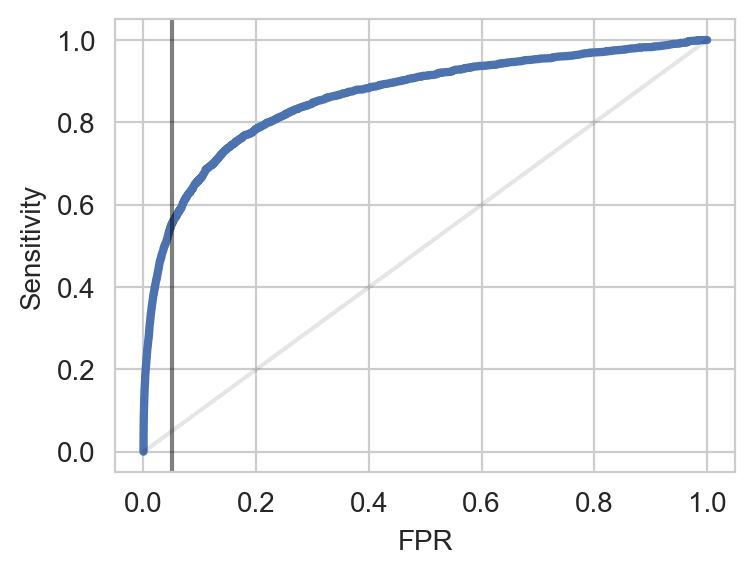

In [110]:
fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
plot_cdf(ab_data, 'TTest', ax)
ax.plot(np.linspace(0, 1, 10000), np.linspace(0, 1, 10000), 'k', alpha=0.1)
ax.axvline(0.05, color='k', alpha=0.5)
ax.set_xlabel('FPR')
ax.set_ylabel('Sensitivity')

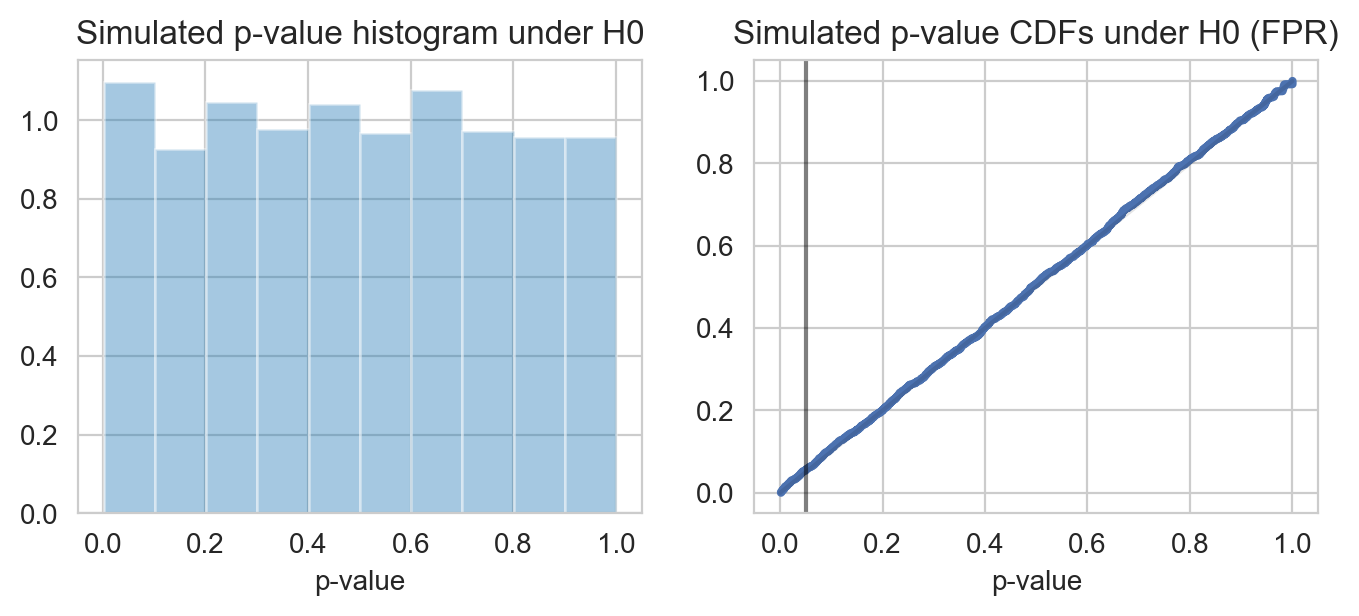

In [123]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(figsize[0] * 2, figsize[1]), dpi=dpi)

# ab_data, aa_data = rpv('../data', 'mannwhitney_successes_count', N=N, NN=NN, uplift=uplift, beta=beta, success_rate=success_rate, skew=0.1)
plot_cdf(aa_data, 'MW', ax2)

ax2.plot(np.linspace(0, 1, 10000), np.linspace(0, 1, 10000), 'k', alpha=0.1)
ax2.axvline(0.05, color='k', alpha=0.5)
ax2.set_title('Simulated p-value CDFs under H0 (FPR)')
ax2.set_xlabel('p-value')

ax1.set_title('Simulated p-value histogram under H0')
ax1.set_xlabel('p-value')
sns.distplot(aa_data.flatten(), ax=ax1, bins=10, kde=False, norm_hist=True)

TODO: под каждый вывод - отдельная картинка!